# Day 17 - Compression

* https://adventofcode.com/2019/day/17

Part 1 is just a checksum to verify you are correctly loading the data. I couldn't resist sprucing up the map a bit by using tiles instead of printing lines.

In [1]:
from __future__ import annotations
from collections import deque
from dataclasses import dataclass, field
from enum import Enum
from io import BytesIO
from typing import (
    cast,
    ContextManager,
    Deque,
    Dict,
    Generator,
    Generic,
    Iterator,
    List,
    Literal,
    MutableMapping,
    NamedTuple,
    Optional,
    Set,
    Tuple,
    TypeVar,
    TYPE_CHECKING,
)

import numpy as np
from IPython.display import display
from PIL import Image, ImageDraw
from PIL.ImagePalette import ImagePalette

from intcode import CPU, Instruction, InstructionSet, base_opcodes


TILESIZE = (16, 16)


class Pos(NamedTuple):
    x: int = 0
    y: int = 0
        
    def __mul__(self, factor: int) -> Pos:
        if isinstance(factor, int):
            return self._replace(x=self.x * factor, y=self.y * factor)
        return NotImplemented

    def __add__(self, other: Pos) -> Pos:  # type: ignore
        if isinstance(other, Pos):
            return self._replace(x=self.x + other.x, y=self.y + other.y)
        return NotImplemented
    
    def __sub__(self, other: Pos) -> Pos:
        if isinstance(other, Pos):
            return self._replace(x=self.x - other.x, y=self.y - other.y)
        return NotImplemented

    @property
    def alignment_parameter(self):
        return abs(self.x) * abs(self.y)


class Tile:
    _img: Image.Image
    
    @staticmethod
    def _img_from_patch(patch: bytes, colour: int) -> Image.Image:
        patch = np.unpackbits(
            np.frombuffer(patch, dtype=np.uint8).reshape(-1, TILESIZE[0] // 8),
            axis=1
        )
        return Image.fromarray(patch * colour, "P")

    def put(self, screen: Image, pos: Pos) -> None:
        img = self._img
        screenpos = pos * TILESIZE[0]  # tiles are square
        screen.paste(img, tuple(screenpos))


class VacuumRobotDirection(Tile, Enum):
    # ASCII character as output by Intcode, patch bytes (32), left, right, delta
    up    = (
        "^", 
        b"\x00\x00\x00\x00\x01\x80\x01\x80"
        b"\x03\xc0\x03\xc0\x07\xe0\x0e\x70"
        b"\x1c\x38\x38\x1c\x38\x1c\x30\x0c"
        b"\x30\x0c\x30\x0c\x00\x00\x00\x00",
        "left",
        "right",
        Pos(0, -1),
    )
    down  = (
        "v",
        b"\x00\x00\x00\x00\x30\x0c\x30\x0c"
        b"\x30\x0c\x38\x1c\x38\x1c\x1c\x38"
        b"\x0e\x70\x07\xe0\x03\xc0\x03\xc0"
        b"\x01\x80\x01\x80\x00\x00\x00\x00",
        "right",
        "left",
        Pos(0, 1),
    )
    left  = (
        "<",
        b"\x00\x00\x00\x00\x00\x7c\x00\xfc"
        b"\x01\xe0\x03\x80\x0f\x00\x3e\x00"
        b"\x3e\x00\x0f\x00\x03\x80\x01\xe0"
        b"\x00\xfc\x00\x7c\x00\x00\x00\x00",
        "down",
        "up",
        Pos(-1, 0),
    )
    right = (
        ">",
        b"\x00\x00\x00\x00\x3e\x00\x3f\x00"
        b"\x07\x80\x01\xc0\x00\xf0\x00\x7c"
        b"\x00\x7c\x00\xf0\x01\xc0\x07\x80"
        b"\x3f\x00\x3e\x00\x00\x00\x00\x00",
        "up",
        "down",
        Pos(1, 0),
    )
    
    if TYPE_CHECKING:
        _delta: Pos
        _left: str
        _right: str
    
    def __new__(
        self,
        value: int,
        patch: Optional[bytes] = None,
        left: Optional[str] = None,
        right: Optional[str] = None,
        delta: Optional[Pos] = None,
    ) -> VacuumRobotState:
        self = object.__new__(self)
        self._value_ = value
        assert patch is not None
        assert delta is not None
        assert left is not None and right is not None
        # 255 is the conventional index for 'white'
        self._img = self._img_from_patch(patch, 255)
        self._left, self._right = left, right
        self._delta = delta
        return self

    def move(self, pos: Pos) -> None:
        return pos + self._delta

    @property
    def turn_left(self) -> VacuumRobotDirection:
        return VacuumRobotDirection[self._left]

    @property
    def turn_right(self) -> VacuumRobotDirection:
        return VacuumRobotDirection[self._right]


class ScaffoldTile(Tile, Enum):
    # character, patch (32 bytes), palette colour index
    space = (".", b"\x00" * 32, 0)
    scaffold = ("#",
        b"\x00\x00\x3f\xfc\x7f\xfe\x60\x06"
        b"\x74\x86\x60\x26\x71\x06\x64\x06"
        b"\x70\xa6\x62\x06\x74\x56\x60\x06"
        b"\x75\x56\x7f\xfe\x3f\xfc\x00\x00",
        1
    )
    intersection = ("O",
        b"\x00\x00\x07\xe0\x0f\xf0\x1f\xf8"
        b"\x3c\x3c\x78\x1e\x70\x0e\x70\x0e"
        b"\x70\x0e\x70\x0e\x78\x1e\x3c\x3c"
        b"\x1f\xf8\x0f\xf0\x07\xe0\x00\x00",
        2
    )

    def __new__(
        self,
        value: int,
        patch: Optional[bytes] = None,
        colour: Optional[int] = None,
    ) -> ScaffoldTile:
        self = object.__new__(self)
        self._value_ = value
        assert patch is not None
        assert colour is not None
        self._img = self._img_from_patch(patch, colour)
        return self


PALETTE: ImagePalette = ImagePalette(
    "RGB",
    [v for c in zip(*(
        (0x00, 0x00, 0x00),  # black, space
        (0xd2, 0x69, 0x1e),  # chocolate, scaffold
        (0x00, 0xbf, 0xff),  # deepskyblue, intersection
        *([(0x00, 0x00, 0x00)] * (256 - 4)),  # unassigned
        (0xff, 0xff, 0xff),  # white, vacuum robot
    )) for v in c],
    256 * 3
)
    

@dataclass
class ScaffoldMap(MutableMapping[Pos, Tile]):
    _tiles: Dict[Pos, Tile] = field(default_factory=dict)
    _xrange: range = range(0)
    _yrange: range = range(0)
    _masked_positions: Dict[Pos, Tile] = field(default_factory=dict)
    _image: Optional[Image.Image] = None
    _intersections: Set[Pos] = field(default_factory=set)
        
    def _create_image(self, width: int, height: int) -> Image.Image:
        self._image = img = Image.new('P', (width, height))
        img.putpalette(PALETTE)
        return img
        
    def _update_image(
        self,
        pos: Optional[Pos] = None,
        tile: Optional[Tile] = None
    ) -> None:
        old = self._xrange, self._yrange
        if pos is not None:
            x, y = pos        
            if x < self._xrange.start:
                self._xrange = range(x, self._xrange.stop)
            elif x >= self._xrange.stop:
                self._xrange = range(self._xrange.start, x + 1)
            if y < self._yrange.start:
                self._yrange = range(y, self._yrange.stop)
            elif y >= self._yrange.stop:
                self._yrange = range(self._yrange.start, y + 1)
        else:
            self._xrange = range(
                min(x for x, _ in self._tiles),
                max(x for x, _ in self._tiles) + 1,
            )
            self._yrange = range(
                min(y for _, y in self._tiles),
                max(y for _, y in self._tiles) + 1,
            )

        if (self._xrange, self._yrange) != old:
            minx, miny = self._xrange.start, self._yrange.start
            W, H = len(self._xrange) * TILESIZE[0], len(self._yrange) * TILESIZE[1]
            img = self._create_image(W, H)
            for pos, tile in self._tiles.items():
                tile.put(img, pos)
            for pos, tile in self._masked_positions.items():
                tile.put(img, pos)
        elif pos is not None and tile is not None:
            tile.put(self._image, pos)
    
    def mask_tile(self, pos: Pos, tile: Optional[Tile] = None) -> None:
        # overlay another tile on the map, like the vacuum robot
        # or marking an intersection.
        if tile is None and pos in self._masked_positions:
            del self._masked_positions[pos]
            tile = self._tiles.get(pos)
        elif tile:
            self._masked_positions[pos] = tile
        if self._image is not None and tile:
            tile.put(self._image, pos)
            
    @property
    def intersections(self) -> Set[Pos]:
        if not self._intersections:
            scaffoldpositions: Set[Pos] = {
                pos for pos, tile in self._tiles.items()
                if tile is ScaffoldTile.scaffold
            }
            directions = (Pos(-1, 0), Pos(0, 1), Pos(1, 0), Pos(0, -1))
            for pos in scaffoldpositions:
                if all(pos + d in scaffoldpositions for d in directions):
                    self._intersections.add(pos)
        return self._intersections

    def __iter__(self) -> Iterator[Pos]:
        return iter(self._tiles)
    
    def __len__(self) -> int:
        return len(self._tiles)

    def __getitem__(self, pos: Pos) -> ScaffoldTile:
        return self._tiles.get(pos, ScaffoldTile.space)
    
    def __setitem__(self, pos: Pos, tile: Tile) -> None:
        self._tiles[pos] = tile
        self._update_image(pos, tile)

    def __delitem__(self, pos: Pos) -> None:
        del self._tiles[pos]
        self._update_image()
        if pos.x in self._xrange and pos.y in self._yrange:
            ScaffoldTile.space.put(self._image, pos)
        
    def _repr_png_(self) -> bytes:
        img = self._image
        if img is None:
            img = Image.new('P', (1, 1))
        f = BytesIO()
        img.save(f, "PNG")
        return f.getvalue()


ImagerRunner = Generator[None, int, None]


class ScaffoldImager(ContextManager[ImagerRunner]):
    scaffold_map: ScaffoldMap
    robot_pos: Pos
    robot_direction: VacuumRobotDirection
    _runner: Optional[ImagerRunner] = None

    def __init__(self):
        self.scaffold_map = ScaffoldMap()

    def powerdown(self) -> None:
        if self._runner is not None:
            self._runner.close()
            self._runner = None
    
    def __enter__(self) -> ImagerRunner:
        if self._runner is None:
            self._runner = self.run()
            # prime the runner, so it is waiting for input
            next(self._runner)
        return self._runner
    
    def __exit__(self, *exc) -> None:
        self.powerdown()
        
    def run(self) -> ImagerRunner:
        map = self.scaffold_map
        pos: Pos = Pos()
            
        while True:
            char = chr((yield None))
            if char == "\n":
                # newline, back to x=0, increment y
                pos = Pos(0, pos.y + 1)
                continue

            try:
                map[pos] = ScaffoldTile(char)
            except ValueError:
                self.robot_pos = pos
                self.robot_direction = VacuumRobotDirection(char)
                map[pos] = ScaffoldTile.scaffold
                map.mask_tile(pos, self.robot_direction)

            pos += Pos(1, 0)

        
def load_map(memory: List[int]) -> Tuple[Pos, VacuumRobotDirection, ScaffoldMap]:
    imager = ScaffoldImager()
    with imager as runner:
        opcodes: InstructionSet = {
            **base_opcodes,
            4: Instruction(runner.send, 1),
        }
        CPU(opcodes).reset(memory).execute()
    return imager.robot_pos, imager.robot_direction, imager.scaffold_map
    
def calibrate(scaffold_map: ScaffoldMap) -> int:
    return sum(p.alignment_parameter for p in scaffold_map.intersections)

In [2]:
import aocd
data = aocd.get_data(day=17, year=2019)
memory = list(map(int, data.split(',')))

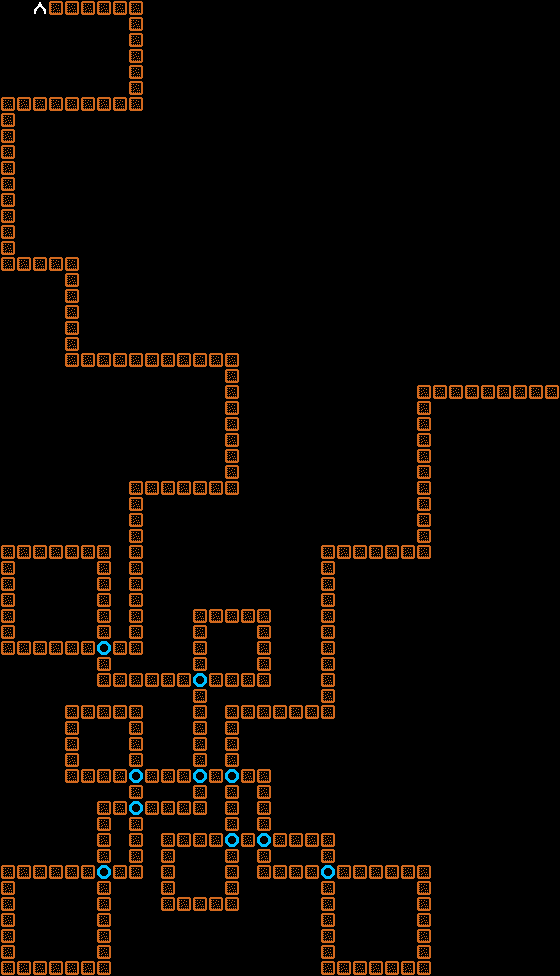

Part 1: 5740


In [3]:
robot_pos, robot_direction, scaffold_map = load_map(memory)
# mark intersections for visual interest:
for pos in scaffold_map.intersections:
    scaffold_map.mask_tile(pos, ScaffoldTile.intersection)
display(scaffold_map)
print("Part 1:", calibrate(scaffold_map))

## Part 2

Part 2 is the interesting part we have to figure out how to express a complete traversal of the scaffolds using just 3 repeated sets of instructions, with each of the 4 inputs (what functions to use, and each function definition), limited to 20 ASCII characters (so at most 10 calls to A, B and C, and *up to* 10 movement instructions; double-digit movements count extra).

First, we need to figure out how to traverse the scaffolds, then find 3 component patterns we can use. At first I generated all possible paths, but that was a sufficiently complicated task, generating over a thousand complete routes, that I dropped that approach as improbable. Instead, we generate the path by going straight until there is no other option but to turn.

Then, for the given path, we need to find if we can find 3 repeated patterns that together can be used to re-create the path.

I've opted to use A* path finding here. We need:

* a function that can generate valid main routines (a combination of the letters A, B, and C) from an arbitrary set of functions (sequences of turns and forward step counts), plus the total distance that the program can cover. It should work with fewer than 3 functions, however.
* a way to generate functions, ideally based on the route:
    * start with empty functions
    * generate main programs with the functions we have
    * if a function is empty, take the maximum number of steps from the furthest we can reach as a new function.
    * iterate until we have three functions.
    * if we have three functions, instead of generating functions, remove steps, one by one. If the last function is emptied, shorted the middle function and generate a new 3rd function. If the second function is emptied, take away steps from the first.
    * Use the reach (the maximum number of steps we can travel along the route with the functions) as the heuristic to narrow the search space.

In [4]:
from collections import Counter
from heapq import heapify, heappush, heappop
from itertools import count, permutations
from typing import Literal, MutableSequence, TypedDict, Union


Movement = Union[Literal["L", "R"], int]
FunctionName = Literal["A", "B", "C"]


class MovementFunctions(TypedDict):
    main: Sequence[FunctionName]
    A: Sequence[Movement]
    B: Sequence[Movement]
    C: Sequence[Movement]


def generate_scaffold_route(
    pos: Pos,
    direction: VacuumRobotDirection,
    scaffold_map: ScaffoldMap
) -> Iterator[Movement]:
    scaffolds: Set[Pos] = {
        p for p, t in scaffold_map.items() if t is ScaffoldTile.scaffold
    }
    
    while True:
        if (forward := direction.move(pos)) in scaffolds:
            yield 1
            pos = forward
        elif (left := direction.turn_left).move(pos) in scaffolds:
            yield "L"
            direction = left
        elif (right := direction.turn_right).move(pos) in scaffolds:
            yield "R"
            direction = right
        else:
            return

        
T = TypeVar("T")


class PriorityQueue(Generic[T]):
    def __init__(self, *initial: Tuple[int, T]) -> None:
        self._queue: List[Tuple[int, int, T]] = []
        self._count = count()
        for pri, item in initial:
            self.put(pri, item)
        heapify(self._queue)

    def __len__(self) -> int:
        return len(self._queue)

    def put(self, pri: int, item: T) -> None:
        heappush(self._queue, (pri, next(self._count), item))

    def get(self) -> T:
        if not self:
            raise ValueError('Queue is empty')
        return heappop(self._queue)[-1]


class FunctionTooLong(ValueError):
    pass
    

class Function(MutableSequence[Movement]):
    _steps: List[Movement]
    expanded: List[Movement]
    
    def __init__(self, it: Optional[Iterable[Movement]] = None) -> None:
        if it is None:
            it = []
        self._steps = list(it)
        self._expand()
        
    def _checklength(self):
        if len(",".join(map(str, self._steps))) > 20:
            raise FunctionTooLong
        
    def _expand(self) -> None:
        self.expanded = [
            m
            for s in self._steps 
            for m in ([s] if s in {"L", "R"} else [1] * s)
        ]
        
    def __repr__(self) -> str:
        return f"<Function {self._steps!r}>"
        
    def __getitem__(self, i: int) -> Movement:
        return self._steps[i]
    
    def __setitem__(self, i: int, step: Movement) -> None:
        self._steps[i] = step
        self._expand()

    def __delitem__(self, i: int) -> None:
        del self._steps[i]
        self._expand()
        
    def __len__(self) -> int:
        return len(self._steps)
    
    def insert(self, i: int, step: Movement) -> None:
        self._steps.insert(i, step)
        self._checklength()
        self._expand()
        
    def append(self, step: Movement) -> None:
        if self._steps and step == 1 and self._steps[-1] not in {"L", "R"}:
            self._steps[-1] += 1
        else:
            self._steps.append(step)
        self._checklength()
        if step in {"L", "R"}:
            self.expanded.append(step)
        else:
            self.expanded.extend([1] * step)


@dataclass(unsafe_hash=True)
class CompressionState:
    reach: int = field(compare=False)
    main: Tuple[FunctionName]
    functions: List[Function] = field(compare=False)
    state: Tuple[str, ...] = field(init=False, repr=False)
    
    def __post_init__(self):
        self.state = tuple(sorted(str(f) for f in self.functions))

    def moves(self, route: Sequence[Movement]) -> Iterator[CompressionState]:
        functions = list(self.functions)
        # trim functions
        while functions:
            f = Function(functions.pop())
            if f[-1] not in {"L", "R"} and f[-1] > 1:
                f[-1] -= 1
            else:
                f.pop()
            if f:
                functions.append(f)
                break
                
        # generate new states, including new functions if we are short
        queue = deque([functions])
        while queue:
            functions = queue.pop()
            if len(functions) == 3:
                for r, m in generate_main_routines(route, *functions):
                    yield CompressionState(r, m, [Function(f) for f in functions])
                continue

            # not enough functions, generate new based on reach
            for reach, _ in generate_main_routines(route, *functions):
                f = Function()
                for i in count(reach):
                    try:
                        f.append(route[i])
                    except (FunctionTooLong, IndexError):
                        break
                queue.append([*functions, f])


def generate_main_routines(
    route: Sequence[Movement],
    *func: Function
) -> Iterator[Tuple[int, Sequence[FunctionName]]]:
    functions = {n: f for n, f in zip("ABC", func)}
    stack = deque([(0, ())])
    while stack:
        pos, main = stack.pop()
        stacklen = len(stack)
        if pos == len(route):
            yield pos, main
            continue
        for n, f in functions.items():
            end = pos + len(f.expanded)
            if route[pos : end] == f.expanded and len(main) < 10:
                stack.append((end, (*main, n)))
        if len(stack) == stacklen:
            # no further progress with this combo
            yield pos, main
    

def compress(route: Sequence[Movement]):
    startstate = CompressionState(0, (), [])
    queue: PriorityQueue[CompressionState] = PriorityQueue(
        (startstate.reach, startstate)
    )
    closed = set()

    while queue:
        current = queue.get()
        if current.reach == len(route):
            return {"main": current.main, **{n: tuple(f) for n, f in zip("ABC", current.functions)}}

        closed.add(current)
        for neighbor in current.moves(route):
            if neighbor in closed:
                continue
            queue.put(neighbor.reach, neighbor)


testroute = Function([
    "R", 8, "R", 8, "R", 4, "R", 4, "R", 8, "L", 6, "L", 2,
    "R", 4, "R", 4, "R", 8, "R", 8, "R", 8, "L", 6, "L", 2
]).expanded
testfunctions = [
    Function(["R", 8, "R", 8]),
    Function(["R", 4, "R", 4, "R", 8]),
    Function(["L", 6, "L", 2]),
]
assert next(generate_main_routines(testroute, *testfunctions)) == (94, ("A", "B", "C", "B", "A", "C"))

In [5]:
from intcode import ioset

def dust_collection(pos: Pos, direction: VacuumRobotDirection, scaffold_map: ScaffoldMap) -> int:
    route = list(generate_scaffold_route(pos, direction, scaffold_map))
    program = compress(route)
    
    def encode(values: Any, end=b"\n") -> bytes:
        return ",".join(map(str, values)).encode() + end

    inputs = [
        *encode(program["main"]),
        *encode(program["A"]),
        *encode(program["B"]),
        *encode(program["C"]),
        *encode("n"),
    ]
    print("Programme:", bytes(inputs[:-2]).decode(), sep="\n")
    outputs, opcodes = ioset(*inputs)
    CPU(opcodes).reset([2, *memory[1:]]).execute()
    return outputs[-1]

In [6]:
print("Part 2:", dust_collection(robot_pos, robot_direction, scaffold_map))

Programme:
A,B,B,A,C,A,C,A,C,B
R,6,R,6,R,8,L,10,L,4
R,6,L,10,R,8
L,4,L,12,R,6,L,10

Part 2: 1022165
